# Project 4: Final Ethylene Reactor Model

### Final model of the ethylene reactor: temperature fluctuations due to reaction are taken into account (non-isothermal model) in addition to previous corrections. 

<img src="Images/PFRMassBalance.png" alt="PFR" width="610"/>

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-white')

In [3]:
#Step size and total number of iterations
pi = np.pi
s = 0.1
length = 100
z = np.arange(0,length+s,s)   # Have to adjust step vector since python rounds down
S = len(z)                    # Total iterations

# Parameters
d = 10.0/100.0;
r = d/2
r_o = r + 0.003
R_g = 8.3145
A_i = pi*r**2
A_o = pi*(r+.003)**2

# Also turn molecular weights into an array (in order of E,Y,H,P,M,L,A,B,W)
MW = [30.069, 28.0532, 2.01588, 44.0956, 16.0425, 42.0797, 26.0373, 54.0904, 18.01528]

In [4]:
# Find average viscosities according to Graham's model since Herning and Zipperer assume low Hydrogen. [1]
def mu(N,T):
  # Use DIPPR values for viscosity data into arrays. Order for values is [E,Y,H,P,M,L,A,B,W]
  A = [2.5906E-07, 2.0789E-06, 1.797E-07, 4.9054E-08, 5.2546E-07, 7.3919E-07, 1.2025E-06, 2.696E-07, 1.7096e-8]
  B = [0.67988, 0.4163, 0.685, 0.90125, 0.59006, 0.5423, 0.4952, 0.6715, 1.1146]
  C = [98.902, 352.7, -0.59, 0, 105.67, 263.73, 291.4, 134.7, 0]
  D = [0, 0, 140.0, 0, 0, 0, 0, 0, 0]

  Flux_sum = sum(N)
  mol_frac = N/float(Flux_sum)
  Value = 0
  for i in range(len(N)):                                 # Loop to find sum 
    mu_i = float(A[i]*T**B[i]/(1+(C[i]/T)+(D[i]/T**2)))   # Viscosity of componenent i						 
    x_i = mol_frac[i]             		          # Mass fraction of i
    Value += x_i * mu_i
  return(Value)

# Find average heat capacity (C_P) using DIPPR data
def C_p(N,T,vec):
  # Use DIPPR values for C_p data into arrays. Order for values is [E,Y,H,P,M,L,A,B,W]
  A = [44256.0, 33380.0, 27167.0, 59474.0, 33298.0, 43852.0, 36921.0, 50950.0, 33363.0]
  B = [84737.0, 94790.0, 9560.0, 126610.0, 79933.0, 150600.0, 31793.0, 170500.0, 26790.0]
  C = [872.24, 1596.0, 2466.0, 844.31, 2086.9, 1398.8, 678.05, 1532.4, 2610.5]
  D = [67130.0, 55100.0, 3760.0, 86165.0, 41602.0, 74754.0, 33430.0, 133700.0, 8896.0]
  E = [2430.4, 740.8, 567.6, 2482.7, 991.96, 616.46, 3036.6, 685.6, 1169.0]

  mol_frac = N/float(np.sum(N))
  Value = 0

  
  if vec:
    vector = np.zeros(len(N))
    for i in range(len(N)):
      vector[i] = float(A[i] + B[i]*(C[i]/(T*math.sinh(C[i]/T)))**2 + D[i]*(E[i]/(T*math.cosh(E[i]/T)))**2)/1000.0 # J/mol-K
    return vector
  
  else:
    for i in range(len(N)):
      C_pi = float(A[i] + B[i]*(C[i]/(T*math.sinh(C[i]/T)))**2 + D[i]*(E[i]/(T*math.cosh(E[i]/T)))**2)  # J/kmol-K
      x_i = mol_frac[i]
      Value += float(x_i * C_pi / MW[i])
    return(Value)  #Return in units J/kg-K

# Use DIPPR correlations to calculate the value of the thermal conductivity of the gas mixture (k_T)
def k_gas(N,T):
    # Use DIPPR values for viscosity data into arrays. Order for values is [E,Y,H,P,M,L,A,B,W]
  A = [ 0.000073869, 8.6806E-06, 0.002653, -1.12, 8.3983E-06, 0.0000449, 0.000075782, -20890.0, 6.2041E-06]
  B = [1.1689, 1.4559, 0.7452, 0.10972, 1.4268, 1.2018, 1.0327, 0.9593, 1.3973]
  C = [500.73, 299.72, 12.0, -9834.6, -49.654, 421.0, -36.227, -93820000000.0, 0]
  D = [0, -29403.0, 0, -7535800.0, 0, 0, 31432.0, 0, 0]

  Flux_sum = sum(N)
  mol_frac = N/float(Flux_sum)
  Value = 0
  for i in range(len(N)):                                 # Loop to find sum 
    mu_i = float(A[i]*T**B[i]/(1+(C[i]/T)+(D[i]/T**2)))   # Viscosity of componenent i             
    x_i = float(mol_frac[i])                              # Mole fraction of i
    Value += x_i * mu_i
  return(Value)


In [5]:
# Thermal conductivity of steel from NIST (Range for temperature is 298-1633 K)
k_s = lambda T: 10.33 + 15.54e-3*T - 7e-7*T**2


# Determine rate constants by temperature
K1f = lambda x: (4.652e13)*math.exp(-32811.73924/x)
K1r = lambda x: ((8.75e8)/1000)*math.exp(-16456.19437/x)
K2  = lambda x: (3.850e11)*math.exp(-32836.90161/x)
K5f = lambda x: (9.814e8)*math.exp(-18579.89897/x)
K5r = lambda x: ((5.87e4)/1000)*math.exp(-3544.372384/x)
K6  = lambda x: ((1.026e12)/1000)*math.exp(-20763.99326/x)
K8  = lambda x: ((7.083e13)/1000)*math.exp(-30411.2485/x)

In [7]:
# Create Reaction Vector for all 7 reactions
R = lambda N,v,T: np.array([
K1f(T)*(N[0]/v),            # Reaction 1
K1r(T)*N[1]*N[2]/(v**2),    # Reaction 2
K2(T)*(N[0]/v),             # Reaction 3
K5f(T)*(N[5]/v),            # Reaction 4
K5r(T)*N[6]*N[4]/(v**2),    # Reaction 5
K6(T)*N[6]*N[1]/(v**2),     # Reaction 6
K8(T)*N[1]*N[0]/(v**2),     # Reaction 7
])

# Heats of formation as a function of T and Heat capacity
H_25 = np.array([-83820, 52510, 0, -104680, -74520, 19710, 228200, 109240, -241814]) # Standard heats of formation from Perry's

Hf = lambda T,C: H_25 + ((T-298)/1000)*Cp       # Heat of formation at any T

# Heats of Reaction
delH = lambda T,C:  np.array([(Hf(T,C)[1] + Hf(T,C)[2]) - Hf(T,C)[0],
                            Hf(T,C)[0] - (Hf(T,C)[1] + Hf(T,C)[2]),
                           (Hf(T,C)[3] + Hf(T,C)[4]) - 2*Hf(T,C)[0],
                           (Hf(T,C)[4] + Hf(T,C)[6]) - Hf(T,C)[5],
                            Hf(T,C)[5] - (Hf(T,C)[4] + Hf(T,C)[6]),
                            Hf(T,C)[7] - (Hf(T,C)[6] + Hf(T,C)[1]),
                            (Hf(T,C)[4] + Hf(T,C)[5]) - (Hf(T,C)[0] + Hf(T,C)[1]) ])

# Temperature ODE (Energy Balance)
dTdz = lambda N,v,T,dPdz,delH_T,U,Cp: -(R(N,v,T).dot(delH_T))/(rho_v*Cp) - (v/(rho_v*Cp))*(dPdz) + (2*U/(rho_v*Cp*(r_o)))*(T_ext - T)


In [8]:
# Array for coefficients to reactions
M_v = np.array([
[-1, 1, -2, 0, 0, 0 , -1],  # Ethane
[1, -1, 0, 0, 0, -1, -1],   # Ethylene
[1, -1, 0, 0, 0, 0, 0],     # Hydrogen
[0, 0, 1, 0, 0, 0, 0],      # Propane
[0, 0, 1, 1, -1, 0, 1],     # Methane
[0, 0, 0, -1, 1, 0, 1],     # Propylene
[0, 0, 0, 1, -1, -1, 0],    # Acetylene
[0, 0, 0, 0, 0, 1, 0],      # 1,3 Butadiene
[0, 0, 0, 0, 0, 0, 0]       # Steam (Inerts)
])


# Set entering fluxes for E, Y, and W 
N, N_array = np.zeros(9), np.zeros((S,9))              # Flux Vector and Flux Matrix
N[0], N[1], N[8] = 99.0/A_i, 1.0/A_i, (66+2.0/3)/A_i   # Set known values for flux
N_array[0,:] = N
T_vals, v_vals = np.zeros(S), np.zeros(S)
T_vals[0], v_vals[0] = 820+273.15 , 173.047554977
# Initialize pressure
P = np.zeros(S)
P[0] = 11*101325.0    # Initial pressure is 11 atm 

# Set temperature
T = 820+273.15        # T = 820 C initially
v = 173.047554977
mu_av = 3.1662825959e-05

# Parameters for dTdz (intial values were obtained from previous code without varying T)
rho_v = 567.249885215       #rho_0*v_0
C_p_0 = 3.715689008049358   # Inlet Cp
T_ext = 1173.15             # Temperature of the wall
mu_av = 3.1662825959e-05    # Inlet viscosity
k = 0.15207419642643266     # Inlet mixture thermal conductivity
mu_av = 3.1662825959e-05    # Inlet viscoisty

In [9]:
# RK4/Euler Loop
for i in range(S-1):

    # Thermodynamic properites 
    mu_av = mu(N,T)  # average viscosity
    mu_wall = mu(N,T_ext)     #Average viscosity at the wall
    Cp = C_p(N,T,False) # Cp as a value
    Cp_vec = C_p(N,T,True) # Need Cp as a vector for calculation of delta H of reaction

    k = k_gas(N,T) # Thermal conductvity of the gas mixture

    # Use correlation from class to find Nusselt number:
    Re = float(rho_v*d/ mu_av)
    Pr = float(Cp*mu_av/k)
    
    Nu = (0.023)*(Re**(0.80)) * (Pr**(1./3)) * ((mu_av/mu_wall)**0.14)

    # Then get convective HT coefficient, and average HT coefficient
    h_i = (float(k)/d)*Nu     #convective heat transfer coefficient

    U = h_i*A_i/2*A_o #Overall heat transfer coefficient

    delH_T = delH(T,Cp_vec)

    # Pressure Change
    dPdz = -(309.66176*(mu_av)**0.25)*v                      # Pressure change along reactor length

    # Velocity
    v = R_g*T*sum(N)/P[i]                                    # Set velocity based on pressure and flux
    Ri = R(N,v,T)
    # RK Loop
    k1 = s*M_v.dot(R(N,v,T))                                 # Sets k1 for all reaction odes
    k1T = s*dTdz(N,v,T,dPdz,delH_T,U,Cp)

    k2 = s*M_v.dot(R(N+0.5*k1, v, T+0.5*k1T))                # Sets k2 for all reaction odes
    k2T = s*dTdz(N+0.5*k1,v,T+0.5*k1T,dPdz,delH_T,U,Cp)


    k3 = s*M_v.dot(R(N+0.5*k2, v, T+0.5*k2T))                # Sets k3 for all reaction odes
    k3T = s*dTdz(N+0.5*k2,v,T+0.5*k2T,dPdz, delH_T,U,Cp)

    k4 = s*M_v.dot(R(N+k3, v, T+k3T))                        # Sets k4 for all reaction odes
    k4T = s*dTdz(N+k3,v,T+k3T,dPdz,delH_T,U,Cp)

    # Matrix Update
    N_array[i+1,:] = N     # Store fluxes to matrix as new row (columns will be componenents: E,Y,H,P,M,L,A,B,W)
    v_vals[i+1] = v        # Store velocities
    T_vals[i+1] = T        # Store temperatures


    # Update Terms
    N += (k1 + 2*k2 + 2*k3 + k4)/6                      # Composition RK4 iteration step
    P[i+1] = P[i] + s*dPdz                              # Euler method iteration step
    T += (k1T + 2*k2T + 2*k3T + k4T)/6                  # Update temperature also by RK4


In [10]:
# Selectivity and Conversion Calculation
N_final = N_array[S-1,:]
products = sum(N_final) - N_final[0]- N_final[8] - N_array[0,1]  # Subtract ethane, steam, and initial ethylene to find total products of rxn
S_y = (N_final[1]- N_array[0,1])/products                        # Selectivity of ethylene will be total Y produced divided by products
Conv = (1 - N_final[0]/N_array[0,0])*100.0
print("The selectivity of ethylene is",round(100*S_y,2),"%")
print('Conversion of ethane is ',Conv,'%')

#Calculate Yield
Yield = N_final[1]/N_array[0,0]
print('Yield: ',Yield)


The selectivity of ethylene is 38.96 %
Conversion of ethane is  19.05839247164551 %
Yield:  0.15192965932862892


In [11]:
# Create Matrix of values for mole fractions to plot
Y_t = np.zeros((S,9))
for i in range(S):            
  N_tot = sum(N_array[i,:])
  Y_t[i,:] = N_array[i,:]/N_tot   

for i in range(len(P)):
  P[i] = P[i]/101325.0

# Calculate dimensionless values  
P_P0, T_T0, v_v0 = np.zeros(S), np.zeros(S), np.zeros(S)
for i in range(S):
  P_P0[i], T_T0[i], v_v0[i] = P[i]/P[0], T_vals[i]/T_vals[0], v_vals[i]/v_vals[0]


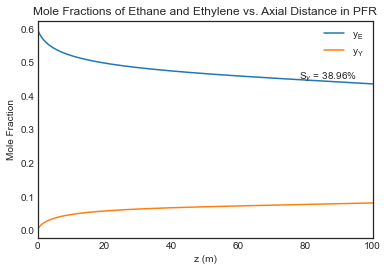

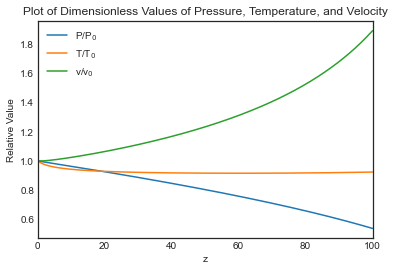

In [12]:
# Plotting 
disp = 'S$_y$ = '+ str(round(100*S_y,2)) + '%'
plt.figure(1)
plt.plot(z, Y_t[:,0], label="$\mathregular{y_E}$")
plt.plot(z, Y_t[:,1], label="$\mathregular{y_Y}$")
plt.xlim(0,length)
plt.text(78,0.45,disp)
plt.legend(loc="upper right")
plt.xlabel("z (m)")
plt.ylabel("Mole Fraction")
plt.title('Mole Fractions of Ethane and Ethylene vs. Axial Distance in PFR')
plt.show()

plt.plot(z, P_P0, label="P/P$_0$")
plt.plot(z, T_T0, label="T/T$_0$")
plt.plot(z, v_v0, label="v/v$_0$")
plt.xlim(0,length)
plt.legend(loc="best")
plt.xlabel('z')
plt.ylabel("Relative Value")
plt.title('Plot of Dimensionless Values of Pressure, Temperature, and Velocity')
plt.show()